# Определение возраста покупателей

## Исследовательский анализ данных

**Анализ размера выборки и график распределения возрастов в выборке**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
try:
    labels = pd.read_csv('labels.csv')
except:
    print('Ошибка загрузки данных')
    
print(labels.info())
print()
print('Размер выборки:', labels.shape)
display(labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None

Размер выборки: (7591, 2)


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


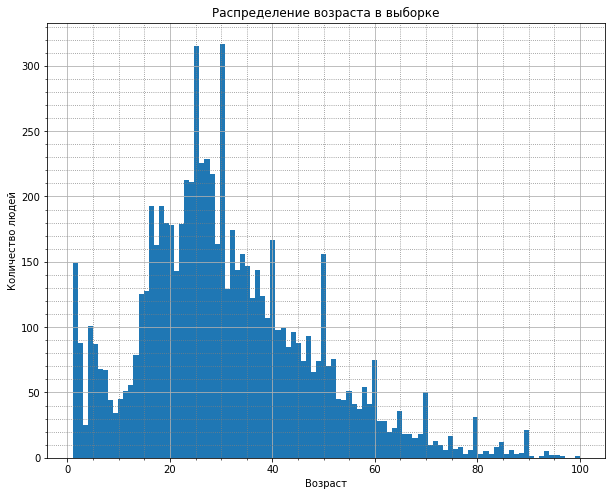

In [4]:
# построение гистаграммы возрастов

ax = labels['real_age'].plot(kind='hist', grid=True, figsize=(10, 8), bins=100)
ax.minorticks_on()
ax.grid(which='minor', color = 'gray', linestyle = ':')
ax.set_title('Распределение возраста в выборке')
ax.set(xlabel='Возраст', ylabel='Количество людей')
plt.show()

Found 7591 validated image filenames.


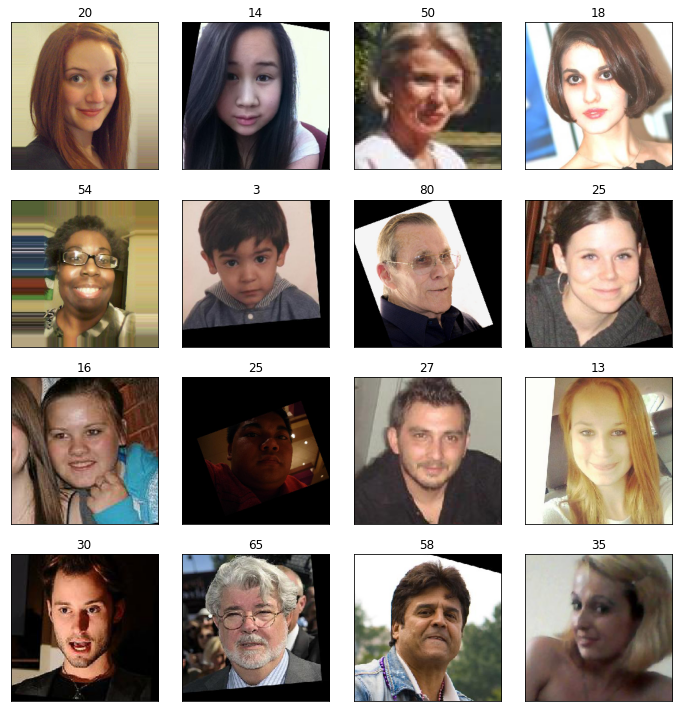

In [5]:
# создание загрузчика и загрузка данных для просмотра устройста датасета

labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1/255)

datagen_flow = datagen.flow_from_dataframe(
                dataframe=labels,
                directory='/datasets/faces/final_files',
                x_col='file_name',
                y_col='real_age',
                class_mode='raw')



features, target = next(datagen_flow)

# вывод 16 изображений

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

**ВЫВОД**

В имеющемся датасете не очень большое количество фотографий (7951 фотография), что означает, что к данным при построении модели следует применить аугментацию. В датасете имеются фотографии людей разных возрастов, от детей до людей преклонного возраста. На фотографиях лица людей показаны с разных углов, но в основном в анфас, на некоторых фотографиях люди в очках или головных уборах, фотографии различной цветности: цветные и чёрно-белые. Представлены фотографии людей разных рас. При аугментации можно применить отражения при горизонтали, изменение яркости/контрастности, кропы, изменение размера.

## Обучение модели

**Код обучения модели и её результат вывода на экран**

```python
import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
                         
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       rescale=1/255)
                         
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory=path+'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345)
    

    return train_datagen_flow
                
def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
                         
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1/255)
                         
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                         directory=path+'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=12345)

    return test_datagen_flow
 
def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=20, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', 
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 53s - loss: 256.8731 - mae: 11.7225 - val_loss: 603.0837 - val_mae: 19.5596
Epoch 2/10
178/178 - 44s - loss: 103.4087 - mae: 7.7378 - val_loss: 509.9567 - val_mae: 17.4082
Epoch 3/10
178/178 - 44s - loss: 79.8007 - mae: 6.7328 - val_loss: 214.7752 - val_mae: 11.1006
Epoch 4/10
178/178 - 39s - loss: 61.5714 - mae: 5.9707 - val_loss: 168.6357 - val_mae: 10.4538
Epoch 5/10
178/178 - 39s - loss: 51.6464 - mae: 5.4055 - val_loss: 121.8377 - val_mae: 8.6566
Epoch 6/10
178/178 - 40s - loss: 42.6357 - mae: 4.9372 - val_loss: 125.8333 - val_mae: 8.2138
Epoch 7/10
178/178 - 39s - loss: 36.1882 - mae: 4.5639 - val_loss: 93.0299 - val_mae: 7.3710
Epoch 8/10
178/178 - 38s - loss: 30.4286 - mae: 4.1993 - val_loss: 74.5173 - val_mae: 6.4118
Epoch 9/10
178/178 - 38s - loss: 26.4878 - mae: 3.9306 - val_loss: 71.9304 - val_mae: 6.2553
Epoch 10/10
178/178 - 38s - loss: 22.5582 - mae: 3.6541 - val_loss: 70.4798 - val_mae: 6.3320


60/60 - 9s - loss: 70.4798 - mae: 6.3320
Test MAE: 6.3320
```

## Анализ обученной модели

Для построения модели использовалась архитектура ResNet50 с самостоятельно добавленной "верхушкой", состоящей из слоя глобального двумерного пулинга усреднением и трёх полносвязных слоёв с функцией активации ReLU, с загруженными предобученными весами без заморозки. Размер батча - 32, оптимизатор - Adam, количество эпох - 10. На последней эпохе немного наблюдалось переобучение.

Полученное значение метрики МАЕ показывает, что модель предсказывает возраст с точностью до шести лет.